In [2]:
import json

import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import xarray as xr

How to change workflow:
* one function to create x array with slope and aspect elev, lc as a single xarray
* second function insret the dem to calculate the Hs to SWE 
* dask to speed up the Hs to SWE process 

In [3]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'OR'

In [4]:
#CSO data path
CSOpath = 'cso-data.geojson'

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

In [5]:
#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("http://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [6]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285
...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182


# DEM

570400.0 4832800.0 652500.0 4955900.0


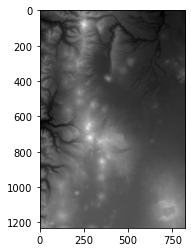

In [7]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

In [8]:
#dem resolution
clX,clY = src.res
print(clX,clY)

100.0 100.0


In [9]:
new=CSO_gdf.to_crs(mod_proj)
new.head()

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (589011.969 4917134.109),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647
1,POINT (606516.821 4879579.232),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006
2,POINT (608833.056 4873347.222),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846
3,POINT (605401.306 4873501.781),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476
4,POINT (589006.439 4917132.330),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285


In [57]:
#add x y values to CSO gdf
CSO_gdf['x']=new.geometry.x
CSO_gdf['y']=new.geometry.y

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,...,Y,M,D,LON,LAT,H,swe,doy,x,y
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,...,2018,1,8,-121.882193,44.402026,0.4826,0.844727,0.419439,589011.968844,4.917134e+06
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,...,2018,1,29,-121.670058,44.061643,2.0500,0.679039,0.950846,606516.820505,4.879579e+06
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,...,2018,1,24,-121.642427,44.005209,2.4000,0.388833,0.894862,608833.055923,4.873347e+06
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,...,2019,12,28,-121.685192,44.007101,0.6350,0.995717,0.726477,605401.305752,4.873502e+06
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,...,2018,5,1,-121.882263,44.402010,1.3208,0.698442,0.034035,589006.438821,4.917132e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0,...,2019,1,25,-121.277959,43.712569,0.8128,0.174131,0.928904,638728.816547,4.841390e+06
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0,...,2019,1,9,-121.689170,44.003075,1.1500,0.849100,0.949531,605089.565795,4.873050e+06
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0,...,2018,1,19,-121.696069,44.026466,1.2000,0.953809,0.275016,604495.341155,4.875639e+06
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0,...,2018,12,1,-121.646195,44.002967,0.8636,0.635188,0.221266,608535.096721,4.873093e+06


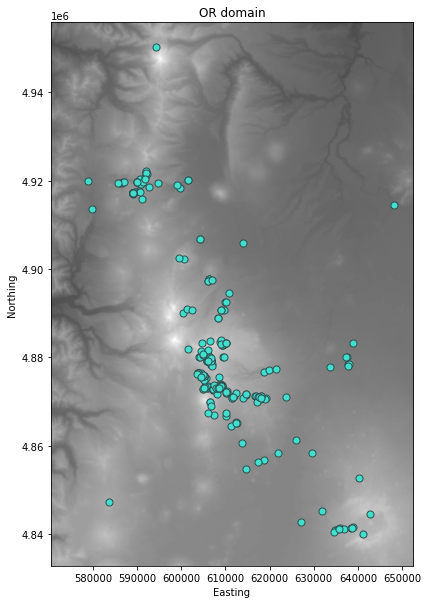

In [10]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title(domain+' domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [11]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(new.geometry.x,new.geometry.y)))

In [12]:
#sample dem
with rio.open(dem_path) as src:
    CSO_gdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736
...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261


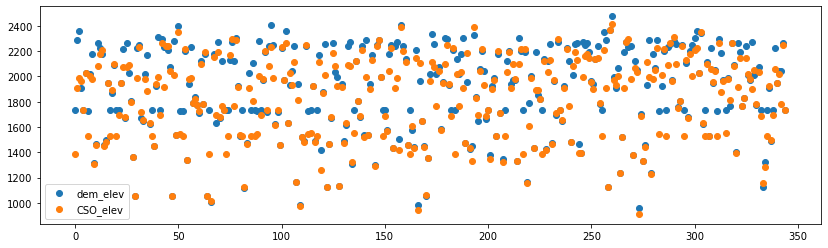

In [13]:
fig, ax = plt.subplots(1,figsize=(14,4))
ax.scatter(CSO_gdf.index.values,CSO_gdf.dem_elev,label='dem_elev')
ax.scatter(CSO_gdf.index.values,CSO_gdf.elevation,label='CSO_elev')
ax.legend()

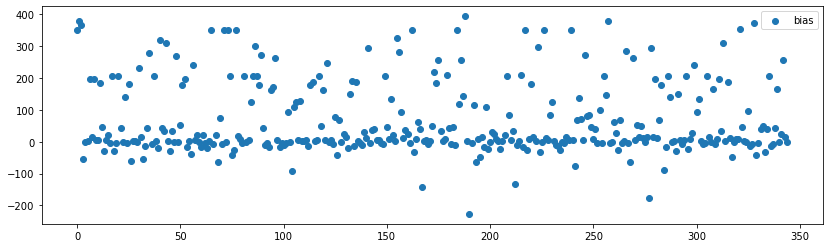

In [14]:
elev_bias = CSO_gdf.dem_elev-CSO_gdf.elevation
fig, ax = plt.subplots(1,figsize=(14,4))
ax.scatter(CSO_gdf.index.values,elev_bias,label='bias')
ax.legend()

elevation categories 

# Slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


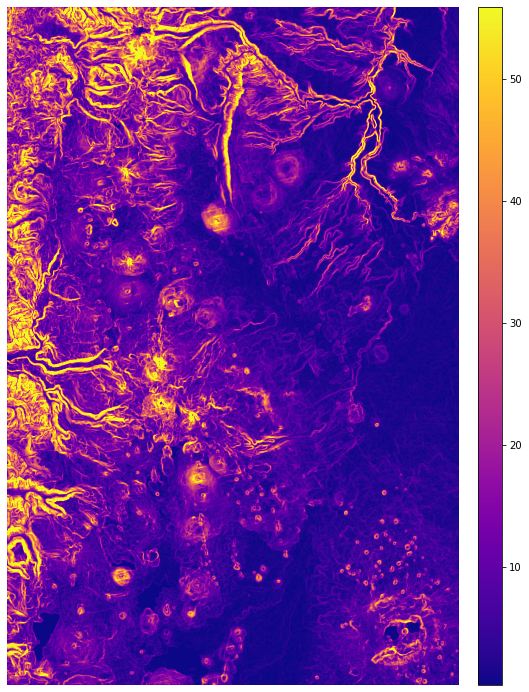

{'vmin': 0.3952847123146057, 'vmax': 55.84605026245117}

In [15]:
import richdem as rd
from osgeo import gdal
ds = gdal.Open(dem_path)
data = np.array(ds.GetRasterBand(1).ReadAsArray())
rda = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='plasma', figsize=(8,10))

In [16]:
with rio.open(dem_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, new.geometry.centroid.x, new.geometry.centroid.y)
CSO_gdf['slope'] = slope[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867
...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398


# Aspect

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


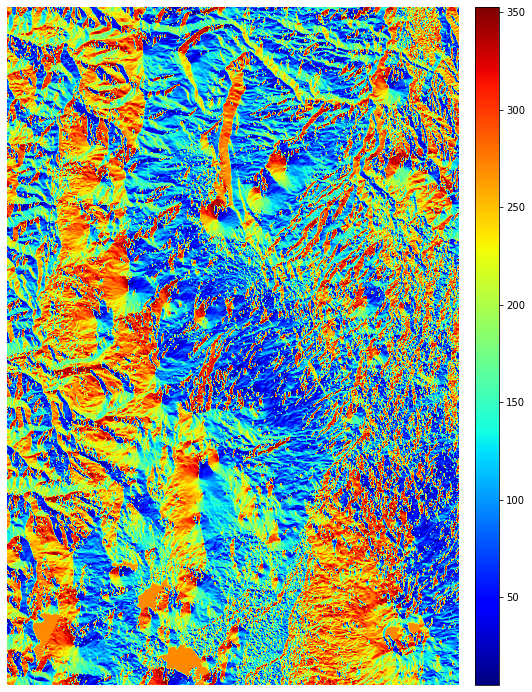

{'vmin': 5.19442892074585, 'vmax': 352.4761657714844}

In [17]:
rda = rd.rdarray(data, no_data=-9999)
aspect = rd.TerrainAttribute(rda, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,10))

In [18]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW, 8=flat
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=202.5)]=4
DIR[(DIR>202.5) & (DIR<=247.5)]=5
DIR[(DIR>247.5) & (DIR<=292.5)]=6
DIR[(DIR>292.5) & (DIR<=337.5)]=7
DIR[(DIR>337.5) & (DIR<=360)]=0
DIR[slope < 0.5]=8
DIR.astype(int)


rdarray([[7, 6, 6, ..., 3, 2, 3],
         [5, 6, 6, ..., 3, 3, 3],
         [5, 6, 6, ..., 3, 2, 2],
         ...,
         [6, 6, 6, ..., 3, 2, 2],
         [4, 5, 6, ..., 3, 3, 3],
         [5, 5, 6, ..., 2, 2, 3]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5]


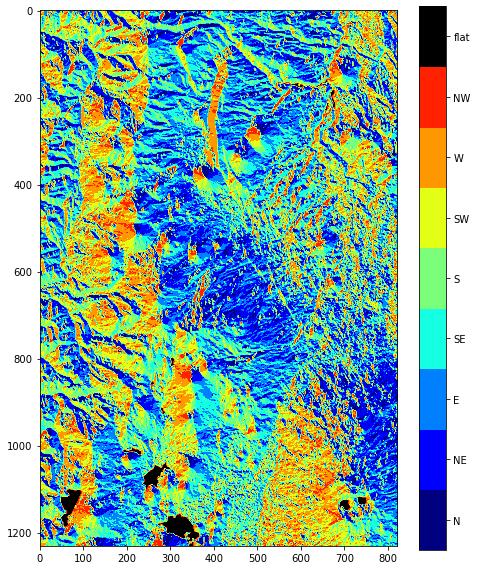

In [19]:
import matplotlib
from matplotlib.colors import ListedColormap

#select colormap
cmap = plt.get_cmap('jet', 9)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:cmap(0), 1:cmap(1), 2:cmap(2), 3:cmap(3), 
          4:cmap(4), 5:cmap(5), 6:cmap(6), 7:cmap(7),8:'black'}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW','flat'])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("aspect.png")
plt.show()

In [20]:
CSO_gdf['aspect'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0
...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0


# Landcover

### Snowmodel LC Codes

|Code  |Landcover Class |Code  |Landcover Class |
| --- | --- | --- | --- |
|1     | coniferous forest |13    | subalpine meadow  |      
|2     | deciduous forest |14    | tundra (non-tussock) |      
|3     | mixed forest |15    | tundra (tussock) |           
|4     | scattered short-conifer |16    | prostrate shrub tundra | 
|5     | clearcut conifer |17    | arctic gram. wetland |       
|6     | mesic upland shrub |18    | bare |       
|7     | xeric upland shrub |19    | water/possibly frozen |       
|8     | playa shrubland |20    | permanent snow/glacier |         
|9     | shrub wetland/riparian |21    | residential/urban |   
|10    | erect shrub tundra |22    | tall crops |       
|11    | low shrub tundra |23    | short crops |        
|12    | grassland rangeland  |24    | ocean |    
      

[ 0.5  1.5  2.5  6.5  9.5 12.5 18.5 20.5 21.5 22.5 23.5 24.5]


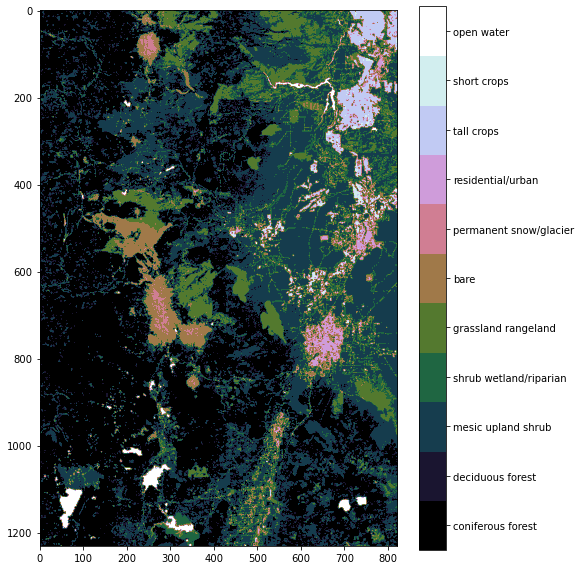

In [21]:
# nlcd path
lc_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/NLCD2016_'+domain+'.tif'


# DEM data
src = rio.open(lc_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
lc = src.read(1)

# #reassign lc from NLCD to SM classes
DIR=DIR=np.empty([np.shape(lc)[0],np.shape(lc)[1]])
DIR[lc == 11 ]=24
DIR[lc == 12 ]=20
DIR[lc == 21 ]=21
DIR[lc == 22 ]=21
DIR[lc == 23 ]=21
DIR[lc == 24 ]=21
DIR[lc == 31 ]=18
DIR[lc == 41 ]=2
DIR[lc == 42 ]=1
DIR[lc == 43 ]=6
DIR[lc == 51 ]=6
DIR[lc == 52 ]=6
DIR[lc == 71 ]=12
DIR[lc == 72 ]=12
DIR[lc == 73 ]=12
DIR[lc == 74 ]=12
DIR[lc == 81 ]=23
DIR[lc == 82 ]=22
DIR[lc == 90 ]=9
DIR[lc == 95 ]=9
DIR.astype(int)

#plot
#select colormap
cmap = plt.get_cmap('cubehelix',11)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
#nlcd
# col_dict={11:'cyan', 12:cmap(1), 21:cmap(2), 22:cmap(3), 23:cmap(4), 
#           24:cmap(5), 31:cmap(6), 41:cmap(7), 42:cmap(8), 43:cmap(9), 
#           52:cmap(10), 71:cmap(11), 81:cmap(12), 82:cmap(13), 90:cmap(14),95:cmap(15)}
#sm
col_dict={1:cmap(0), 2:cmap(1), 6:cmap(2), 9:cmap(3), 12:cmap(4), 
          18:cmap(5), 20:cmap(6), 21:cmap(7), 22:cmap(8), 23:cmap(9), 24:cmap(10)}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category
#nlcd
# labels = np.array(['11', '12', '21', '22', '23', '24', '31', '41',
#                    '42', '43', '52', '71', '81', '82', '90', '95'])
# #sm nums
# labels = np.array(['1', '2', '6', '9', '12', '18', '20', '21',
#                    '22', '23','24'])
#sm names
labels = np.array(['coniferous forest', 'deciduous forest', 'mesic upland shrub', 'shrub wetland/riparian', 
                   'grassland rangeland', 'bare', 'permanent snow/glacier', 'residential/urban',
                   'tall crops', 'short crops','open water'])

len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("lc.png")
plt.show()

# fig, ax = plt.subplots(1,figsize=(8,10))
# im = ax.imshow(src.read(1), cmap='Set3')
# cb = fig.colorbar(im)

In [22]:
#sample lc
CSO_gdf['lc'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,lc
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,1.0
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,18.0
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,18.0
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,1.0
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0,1.0
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0,1.0
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0,1.0
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0,6.0


In [24]:
CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['dt']).dt.date
#CSO_gdf.sort_values(by='dt') 

In [25]:
CSO_gdf['Y'] = pd.DatetimeIndex(CSO_gdf['dt']).year
CSO_gdf['M'] = pd.DatetimeIndex(CSO_gdf['dt']).month
CSO_gdf['D'] = pd.DatetimeIndex(CSO_gdf['dt']).day
CSO_gdf["LON"] = CSO_gdf.geometry.x
CSO_gdf["LAT"] = CSO_gdf.geometry.y
#convert snow depth to m
CSO_gdf['H'] = CSO_gdf.depth/100
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,lc,dt,Y,M,D,LON,LAT,H
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,1.0,2018-01-08,2018,1,8,-121.882193,44.402026,0.4826
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,18.0,2018-01-29,2018,1,29,-121.670058,44.061643,2.0500
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,18.0,2018-01-24,2018,1,24,-121.642427,44.005209,2.4000
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,1.0,2019-12-28,2019,12,28,-121.685192,44.007101,0.6350
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,1.0,2018-05-01,2018,5,1,-121.882263,44.402010,1.3208


In [26]:
print('Total number of CSO in daimain = ',len(CSO_gdf))

Total number of CSO in daimain =  345


# Hs to SWE

In [101]:
################################################################################
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)
print(SWE,DOY)

[0.21318221 0.84688707 0.961015   0.26381443 0.56258088 1.1374902
 0.35085339 0.75529052 0.40417359 0.02631995 0.11967865 0.6063271
 0.40541785 0.88878293 0.78607196 0.71407387 0.50961167 0.16197564
 0.31634728 1.08327055 0.71688189 0.75657639 1.15171957 0.68641781
 0.13953348 0.3812569  0.85430782 0.19028012 0.25320289 0.15564385
 0.51458948 1.61550983 0.21254838 0.46910352 0.44864464 1.57379957
 0.05931483 0.13769957 0.43519824 0.24331176 0.61901092 0.22174505
 2.03706528 0.62617369 0.71889502 0.74054746 0.56337406 0.14205575
 0.37092873 0.10234489 1.1985236  0.14305466 0.15678352 0.69122574
 0.19683328 0.23209857 1.61519033 0.0178565  0.2305964  0.83358056
 1.63388244 0.57370918 0.26461223 0.94486416 0.11391638 0.16080821
 0.31336273 0.94925057 0.09991966 0.28404027 1.4219818  0.63877966
 0.76065386 0.52508802 0.37618623 0.5407952  1.22272064 0.79171914
 0.57840486 0.31156692 0.31465922 0.82603021 0.1383171  0.16824077
 0.27601423 0.72464152 0.78815741 0.54177369 0.07600591 0.232706

In [102]:
CSO_gdf['swe']=SWE
CSO_gdf['doy']=DOY
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,...,Y,M,D,LON,LAT,H,swe,doy,x,y
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,...,2018,1,8,-121.882193,44.402026,0.4826,0.213182,100,589011.968844,4.917134e+06
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,...,2018,1,29,-121.670058,44.061643,2.0500,0.846887,121,606516.820505,4.879579e+06
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,...,2018,1,24,-121.642427,44.005209,2.4000,0.961015,116,608833.055923,4.873347e+06
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,...,2019,12,28,-121.685192,44.007101,0.6350,0.263814,89,605401.305752,4.873502e+06
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,...,2018,5,1,-121.882263,44.402010,1.3208,0.562581,213,589006.438821,4.917132e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0,...,2019,1,25,-121.277959,43.712569,0.8128,0.302929,117,638728.816547,4.841390e+06
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0,...,2019,1,9,-121.689170,44.003075,1.1500,0.479989,101,605089.565795,4.873050e+06
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0,...,2018,1,19,-121.696069,44.026466,1.2000,0.506024,111,604495.341155,4.875639e+06
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0,...,2018,12,1,-121.646195,44.002967,0.8636,0.315298,62,608535.096721,4.873093e+06


In [68]:
new = CSO_gdf[0:3]
new

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,...,Y,M,D,LON,LAT,H,swe,doy,x,y
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,...,2018,1,8,-121.882193,44.402026,0.4826,0.844727,0.419439,589011.968844,4.917134e+06
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,...,2018,1,29,-121.670058,44.061643,2.0500,0.679039,0.950846,606516.820505,4.879579e+06
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,...,2018,1,24,-121.642427,44.005209,2.4000,0.388833,0.894862,608833.055923,4.873347e+06
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,...,2019,12,28,-121.685192,44.007101,0.6350,0.995717,0.726477,605401.305752,4.873502e+06
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,...,2018,5,1,-121.882263,44.402010,1.3208,0.698442,0.034035,589006.438821,4.917132e+06


In [69]:
################################################################################
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(new.Y.values,new.M.values,new.D.values,new.H.values,new.LAT.values,new.LON.values)
print(SWE,DOY)

[0.21318221 0.84688707 0.961015   0.26381443 0.56258088] [100, 121, 116, 89, 213]


# Print data for SM
c A single data file describes the observation information that will be used in the data assimilation.  This file contains the following information in the following format.  The id can be any number, x and y are easting and northing in m, and swe is in m).

```
c   total_number_of_observation_dates_for_this_year
c   iyr imo idy (for this observation date)
c   number_of_stations_for_this_observation_date
c   id x y swe
c   id x y swe
c   id x y swe
c   iyr imo idy (for this observation date)
c   number_of_stations_for_this_observation_date
c   id x y swe
c   id x y swe
```

For example:
```
c   2
c   2014 3 15
c   3
c   101 3456.7 23677.4 0.42
c   102 3556.3 25079.3 0.52
c   103 3106.2 29089.3 0.59
c   2014 4 1
c   2
c   101 3456.7 23677.4 0.48
c   103 3106.2 29089.3 0.62
```

Then this repeats for each year of the assimilation (the inputfile looks like the above for a single-year run, and for multi-year runs the data for each following year is just stacked on top of the previous year).  The example below is for a two-year assimilation run.

In [27]:
swe_dummy = np.random.rand(len(CSO_gdf))
DOY_dummy = np.random.rand(len(CSO_gdf))
CSO_gdf['swe']=swe_dummy
CSO_gdf['doy']=DOY_dummy
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,1.0,2018-01-08,2018,1,8,-121.882193,44.402026,0.4826,0.844727,0.419439
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,18.0,2018-01-29,2018,1,29,-121.670058,44.061643,2.0500,0.679039,0.950846
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,18.0,2018-01-24,2018,1,24,-121.642427,44.005209,2.4000,0.388833,0.894862
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,1.0,2019-12-28,2019,12,28,-121.685192,44.007101,0.6350,0.995717,0.726477
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,1.0,2018-05-01,2018,5,1,-121.882263,44.402010,1.3208,0.698442,0.034035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0,1.0,2019-01-25,2019,1,25,-121.277959,43.712569,0.8128,0.174131,0.928904
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0,1.0,2019-01-09,2019,1,9,-121.689170,44.003075,1.1500,0.849100,0.949531
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0,1.0,2018-01-19,2018,1,19,-121.696069,44.026466,1.2000,0.953809,0.275016
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0,6.0,2018-12-01,2018,12,1,-121.646195,44.002967,0.8636,0.635188,0.221266


In [103]:
outFpath = 'points.dat'
f= open(outFpath,"w+")
 
yrs = np.unique(CSO_gdf['Y'])
yr_count = len(yrs)
for i in range(len(yrs)):
    sel = CSO_gdf.dt[CSO_gdf['Y']==yrs[i]]
    uq_day=np.unique(sel)
    sel_count = len(uq_day)
    f.write('{:02.0f}\n'.format(sel_count))
    for j in range(len(uq_day)):
        obs = CSO_gdf[CSO_gdf['dt']==uq_day[j]]
        d=CSO_gdf.D[CSO_gdf['dt']==uq_day[j]].values
        m=CSO_gdf.M[CSO_gdf['dt']==uq_day[j]].values
        y=CSO_gdf.Y[CSO_gdf['dt']==uq_day[j]].values
        date = str(y[0])+' '+str(m[0])+' '+str(d[0])
        obs_count = len(obs)
        f.write(date+' \n')
        for k in range(len(obs)):
            ids = 100+k
            x= obs.x[obs.index[k]]
            y=obs.y[obs.index[k]]
            swe=obs.swe[obs.index[k]]
            f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
f.close() 

## QC observations 

* 

## Organize data by various methods

* Aspect
* Elevation
* Timing
* Look up ideal temporal spatial analysis 
* Landcover class

vs random sampling 